# OpenCL Vector Addition template
Universität zu Lübeck - Institut für Technische Informatik \
Parallel Computing Systems - WiSe 2025/26 \
Author: Hai Nguyen-Hoang Pham

In [1]:
!lscpu | head -n 10

Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        45 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               16
On-line CPU(s) list:                  0-15
Vendor ID:                            GenuineIntel
Model name:                           Intel(R) Xeon(R) Gold 6154 CPU @ 3.00GHz
CPU family:                           6
Model:                                85


In [2]:
!nvidia-smi

Wed Dec  3 13:36:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40-8Q                  On  | 00000000:02:00.0 Off |                    0 |
| N/A   N/A    P8              N/A /  N/A |      0MiB /  8192MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
# sudo apt install clinfo ocl-icd-opencl-dev opencl-headers
!clinfo | grep "Number of platforms"
!clinfo | grep "Platform Name"

Number of platforms                               2
  Platform Name                                   NVIDIA CUDA
  Platform Name                                   Intel(R) OpenCL
  Platform Name                                   NVIDIA CUDA
  Platform Name                                   Intel(R) OpenCL


In [4]:
%%writefile ocl_vadd.cpp
/**
 * OpenCL Basic Example - Vector Addition
 * 
 * This program demonstrates the fundamental concepts of OpenCL programming:
 * 1. Platform and device discovery
 * 2. Creating OpenCL context and command queue
 * 3. Allocating memory buffers on the GPU
 * 4. Loading and compiling OpenCL kernel source
 * 5. Setting kernel arguments and executing on GPU
 * 6. Reading results back to host
 * 7. Cleanup and resource management
 * 
 * This example shows the OpenCL equivalent of CUDA vector addition,
 * highlighting the differences and similarities between the two approaches.
 */

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <time.h>

#define CL_TARGET_OPENCL_VERSION 200
#define VECTOR_LENGTH 1024*10000*63 // should be a multiple of (1024*10000)
     
#ifdef __APPLE__
#include <OpenCL/opencl.h>
#else
#include <CL/cl.h>
#endif

// OpenCL kernel source code
const char* kernelSource = 
"__kernel void vectorAdd(__global const float* A,\n"
"                       __global const float* B,\n"
"                       __global float* C,\n"
"                       const int numElements) {\n"
"    int i = get_global_id(0);\n"
"    if (i < numElements) {\n"
"        C[i] = A[i] + B[i];\n"
"    }\n"
"}\n";

// Helper function to get error string
const char* getErrorString(cl_int error) {
    switch(error) {
        case CL_SUCCESS: return "Success";
        case CL_DEVICE_NOT_FOUND: return "Device not found";
        case CL_DEVICE_NOT_AVAILABLE: return "Device not available";
        case CL_COMPILER_NOT_AVAILABLE: return "Compiler not available";
        case CL_MEM_OBJECT_ALLOCATION_FAILURE: return "Memory object allocation failure";
        case CL_OUT_OF_RESOURCES: return "Out of resources";
        case CL_OUT_OF_HOST_MEMORY: return "Out of host memory";
        case CL_PROFILING_INFO_NOT_AVAILABLE: return "Profiling info not available";
        case CL_MEM_COPY_OVERLAP: return "Memory copy overlap";
        case CL_IMAGE_FORMAT_MISMATCH: return "Image format mismatch";
        case CL_IMAGE_FORMAT_NOT_SUPPORTED: return "Image format not supported";
        case CL_BUILD_PROGRAM_FAILURE: return "Build program failure";
        case CL_MAP_FAILURE: return "Map failure";
        case CL_INVALID_VALUE: return "Invalid value";
        case CL_INVALID_DEVICE_TYPE: return "Invalid device type";
        case CL_INVALID_PLATFORM: return "Invalid platform";
        case CL_INVALID_DEVICE: return "Invalid device";
        case CL_INVALID_CONTEXT: return "Invalid context";
        case CL_INVALID_QUEUE_PROPERTIES: return "Invalid queue properties";
        case CL_INVALID_COMMAND_QUEUE: return "Invalid command queue";
        case CL_INVALID_HOST_PTR: return "Invalid host pointer";
        case CL_INVALID_MEM_OBJECT: return "Invalid memory object";
        case CL_INVALID_IMAGE_FORMAT_DESCRIPTOR: return "Invalid image format descriptor";
        case CL_INVALID_IMAGE_SIZE: return "Invalid image size";
        case CL_INVALID_SAMPLER: return "Invalid sampler";
        case CL_INVALID_BINARY: return "Invalid binary";
        case CL_INVALID_BUILD_OPTIONS: return "Invalid build options";
        case CL_INVALID_PROGRAM: return "Invalid program";
        case CL_INVALID_PROGRAM_EXECUTABLE: return "Invalid program executable";
        case CL_INVALID_KERNEL_NAME: return "Invalid kernel name";
        case CL_INVALID_KERNEL_DEFINITION: return "Invalid kernel definition";
        case CL_INVALID_KERNEL: return "Invalid kernel";
        case CL_INVALID_ARG_INDEX: return "Invalid argument index";
        case CL_INVALID_ARG_VALUE: return "Invalid argument value";
        case CL_INVALID_ARG_SIZE: return "Invalid argument size";
        case CL_INVALID_KERNEL_ARGS: return "Invalid kernel arguments";
        case CL_INVALID_WORK_DIMENSION: return "Invalid work dimension";
        case CL_INVALID_WORK_GROUP_SIZE: return "Invalid work group size";
        case CL_INVALID_WORK_ITEM_SIZE: return "Invalid work item size";
        case CL_INVALID_GLOBAL_OFFSET: return "Invalid global offset";
        case CL_INVALID_EVENT_WAIT_LIST: return "Invalid event wait list";
        case CL_INVALID_EVENT: return "Invalid event";
        case CL_INVALID_OPERATION: return "Invalid operation";
        case CL_INVALID_GL_OBJECT: return "Invalid GL object";
        case CL_INVALID_BUFFER_SIZE: return "Invalid buffer size";
        case CL_INVALID_MIP_LEVEL: return "Invalid mip level";
        case CL_INVALID_GLOBAL_WORK_SIZE: return "Invalid global work size";
        case -1001: return "Platform not found (CL_PLATFORM_NOT_FOUND_KHR)";
        default: return "Unknown error";
    }
}

// Helper function to check OpenCL errors
void checkError(cl_int error, const char* operation) {
    if (error != CL_SUCCESS) {
        printf("Error during %s: %d (%s)\n", operation, error, getErrorString(error));
        exit(1);
    }
}

void printOpenCLInfo() {
    printf("\n=== OpenCL System Information ===\n");
    
    cl_uint num_platforms = 0;
    cl_int ret = clGetPlatformIDs(0, NULL, &num_platforms);
    
    if (ret != CL_SUCCESS || num_platforms == 0) {
        printf("No OpenCL platforms found!\n");
        printf("\nPossible solutions:\n");
        printf("1. Install OpenCL runtime for your hardware:\n");
        printf("   - NVIDIA GPU: Install CUDA toolkit\n");
        printf("   - AMD GPU: Install ROCm or AMD drivers\n");
        printf("   - Intel CPU/GPU: Install Intel OpenCL runtime\n");
        printf("2. For Ubuntu/Debian:\n");
        printf("   sudo apt-get install ocl-icd-opencl-dev\n");
        printf("   sudo apt-get install nvidia-opencl-dev (for NVIDIA)\n");
        printf("3. Check if your system has any OpenCL-capable devices\n");
        return;
    }
    
    printf("Found %d OpenCL platform(s):\n", num_platforms);
    
    cl_platform_id* platforms = (cl_platform_id*)malloc(num_platforms * sizeof(cl_platform_id));
    ret = clGetPlatformIDs(num_platforms, platforms, NULL);
    
    for (cl_uint i = 0; i < num_platforms; i++) {
        char platform_name[256];
        char platform_vendor[256];
        char platform_version[256];
        
        clGetPlatformInfo(platforms[i], CL_PLATFORM_NAME, sizeof(platform_name), platform_name, NULL);
        clGetPlatformInfo(platforms[i], CL_PLATFORM_VENDOR, sizeof(platform_vendor), platform_vendor, NULL);
        clGetPlatformInfo(platforms[i], CL_PLATFORM_VERSION, sizeof(platform_version), platform_version, NULL);
        
        printf("\nPlatform %d:\n", i);
        printf("  Name: %s\n", platform_name);
        printf("  Vendor: %s\n", platform_vendor);
        printf("  Version: %s\n", platform_version);
        
        // Get devices for this platform
        cl_uint num_devices = 0;
        ret = clGetDeviceIDs(platforms[i], CL_DEVICE_TYPE_ALL, 0, NULL, &num_devices);
        
        if (ret == CL_SUCCESS && num_devices > 0) {
            printf("  Devices: %d\n", num_devices);
            
            cl_device_id* devices = (cl_device_id*)malloc(num_devices * sizeof(cl_device_id));
            ret = clGetDeviceIDs(platforms[i], CL_DEVICE_TYPE_ALL, num_devices, devices, NULL);
            
            for (cl_uint j = 0; j < num_devices; j++) {
                char device_name[256];
                cl_device_type device_type;
                cl_ulong global_mem_size;
                size_t maxWorkGroupSize;
                cl_uint deviceComputeUnits;
                
                clGetDeviceInfo(devices[j], CL_DEVICE_NAME, sizeof(device_name), device_name, NULL);
                clGetDeviceInfo(devices[j], CL_DEVICE_TYPE, sizeof(device_type), &device_type, NULL);
                clGetDeviceInfo(devices[j], CL_DEVICE_GLOBAL_MEM_SIZE, sizeof(global_mem_size), &global_mem_size, NULL);
                clGetDeviceInfo(devices[j], CL_DEVICE_MAX_WORK_GROUP_SIZE, sizeof(size_t), &maxWorkGroupSize, NULL);
                clGetDeviceInfo(devices[j], CL_DEVICE_MAX_COMPUTE_UNITS, sizeof(cl_uint), &deviceComputeUnits, NULL);

                printf("    Device %d: %s", j, device_name);
                if (device_type & CL_DEVICE_TYPE_GPU) printf(" (GPU)");
                else if (device_type & CL_DEVICE_TYPE_CPU) printf(" (CPU)");
                else printf(" (Other)");
                printf(" - %lu MB\n", global_mem_size / (1024 * 1024));
                printf("Device max work group size: %zu\n", maxWorkGroupSize);
                printf("Device max compute units: %u\n", deviceComputeUnits);
            }
            
            free(devices);
        } else {
            printf("  No devices found for this platform\n");
        }
    }
    
    free(platforms);
    printf("\n");
}

double getCurrentTime() {
    struct timespec ts;
    clock_gettime(CLOCK_MONOTONIC, &ts);
    return ts.tv_sec + ts.tv_nsec / 1e9;
}

typedef struct {
    float gpu_portion;
    cl_uint compute_units;
} BenchmarkProfile;

void run_fully_sequential(double *totalTimes, int T) {
    const int numElements = VECTOR_LENGTH;
    const size_t dataSize = numElements * sizeof(float);
    printf("\n========================================\n");
    printf("Benchmark CPU Only\n");
    printf("CPU processing: %d elements\n", numElements);
    printf("Number of iterations: %d\n", T);
    printf("========================================\n\n");
    // Allocate host memory
    float *h_A = (float*)malloc(dataSize);
    float *h_B = (float*)malloc(dataSize);
    float *h_C = (float*)malloc(dataSize);
    // Initialize host arrays
    for (int i = 0; i < numElements; i++) {
        h_A[i] = (float)rand() / RAND_MAX;
        h_B[i] = (float)rand() / RAND_MAX;
    }
    // Run T iterations
    for (int iter = 0; iter < T; iter++) {
        // CPU computation
        double cpu_start = getCurrentTime();
        for (int i = 0; i < numElements; i++) {
            h_C[i] = h_A[i] + h_B[i];
        }
        double cpu_end = getCurrentTime();
        totalTimes[iter] = cpu_end - cpu_start;
    }
    // Display results
    printf("CPU times (s): [");
    for (int i = 0; i < T; i++) {
        printf("%.9f", totalTimes[i]);
        if (i < T - 1) printf(", ");
    }
    printf("]\n");
}

void run_benchmark(float gpu_portion, cl_uint compute_units, double *totalTimes, int T) {
    const int numElements = VECTOR_LENGTH;
    const size_t dataSize = numElements * sizeof(float);
    
    // Calculate workload split based on gpu_portion
    const int gpuElements = (int)(numElements * gpu_portion);
    const int cpuElements = numElements - gpuElements;
    const size_t cpuDataSize = cpuElements * sizeof(float);
    const size_t gpuDataSize = gpuElements * sizeof(float);

    double cpuTimes[T];
    double gpuTimes[T];
    
    printf("\n========================================\n");
    printf("Benchmark Profile: GPU portion=%.0f%%, Compute Units=%u\n", gpu_portion * 100, compute_units);
    printf("CPU processing: %d elements (%.0f%%)\n", cpuElements, (1 - gpu_portion) * 100);
    printf("GPU processing: %d elements (%.0f%%)\n", gpuElements, gpu_portion * 100);
    printf("Number of iterations: %d\n", T);
    printf("========================================\n\n");
    
    cl_platform_id platform_id = NULL;
    cl_device_id device_id = NULL;
    cl_uint ret_num_devices;
    cl_uint ret_num_platforms;
    cl_int ret;
    
    // Get platform
    ret = clGetPlatformIDs(1, &platform_id, &ret_num_platforms);
    if (ret != CL_SUCCESS || ret_num_platforms == 0) {
        printf("ERROR: No OpenCL platforms available!\n");
        return;
    }
    
    // Get device
    ret = clGetDeviceIDs(platform_id, CL_DEVICE_TYPE_GPU, 1, &device_id, &ret_num_devices);
    if (ret != CL_SUCCESS) {
        ret = clGetDeviceIDs(platform_id, CL_DEVICE_TYPE_ALL, 1, &device_id, &ret_num_devices);
        if (ret != CL_SUCCESS) {
            printf("ERROR: No OpenCL devices found!\n");
            return;
        }
    }
    
    if (ret_num_devices == 0) {
        printf("ERROR: No OpenCL devices available!\n");
        return;
    }

    // Allocate host memory
    float *h_A = (float*)malloc(dataSize);
    float *h_B = (float*)malloc(dataSize);
    float *h_C = (float*)malloc(dataSize);
    
    if (!h_A || !h_B || !h_C) {
        printf("Failed to allocate host memory\n");
        return;
    }
    
    // Initialize host arrays
    for (int i = 0; i < numElements; i++) {
        h_A[i] = (float)rand() / RAND_MAX;
        h_B[i] = (float)rand() / RAND_MAX;
    }
    
    // Create OpenCL context
    cl_context context = clCreateContext(NULL, 1, &device_id, NULL, NULL, &ret);
    checkError(ret, "creating context");
    
    // Create command queue
#ifdef CL_VERSION_2_0
    cl_queue_properties props[] = {0};
    cl_command_queue command_queue = clCreateCommandQueueWithProperties(context, device_id, props, &ret);
#else
    cl_command_queue command_queue = clCreateCommandQueue(context, device_id, 0, &ret);
#endif
    checkError(ret, "creating command queue");
    
    // Create memory buffers for GPU portion only
    cl_mem d_A = clCreateBuffer(context, CL_MEM_READ_ONLY, gpuDataSize, NULL, &ret);
    checkError(ret, "creating buffer A");
    
    cl_mem d_B = clCreateBuffer(context, CL_MEM_READ_ONLY, gpuDataSize, NULL, &ret);
    checkError(ret, "creating buffer B");
    
    cl_mem d_C = clCreateBuffer(context, CL_MEM_WRITE_ONLY, gpuDataSize, NULL, &ret);
    checkError(ret, "creating buffer C");
    
    // Copy GPU portion data to device
    ret = clEnqueueWriteBuffer(command_queue, d_A, CL_TRUE, 0, gpuDataSize, &h_A[cpuElements], 0, NULL, NULL);
    checkError(ret, "writing buffer A");
    
    ret = clEnqueueWriteBuffer(command_queue, d_B, CL_TRUE, 0, gpuDataSize, &h_B[cpuElements], 0, NULL, NULL);
    checkError(ret, "writing buffer B");
    
    // Create program and kernel
    cl_program program = clCreateProgramWithSource(context, 1, &kernelSource, NULL, &ret);
    checkError(ret, "creating program");
    
    ret = clBuildProgram(program, 1, &device_id, NULL, NULL, NULL);
    if (ret != CL_SUCCESS) {
        printf("Error building program\n");
        return;
    }
    
    cl_kernel kernel = clCreateKernel(program, "vectorAdd", &ret);
    checkError(ret, "creating kernel");
    
    // Set kernel arguments
    ret = clSetKernelArg(kernel, 0, sizeof(cl_mem), (void*)&d_A);
    ret = clSetKernelArg(kernel, 1, sizeof(cl_mem), (void*)&d_B);
    ret = clSetKernelArg(kernel, 2, sizeof(cl_mem), (void*)&d_C);
    ret = clSetKernelArg(kernel, 3, sizeof(int), (void*)&gpuElements);

    // Calculate work size
    size_t globalWorkSize = gpuElements;
    size_t localWorkSize = 256;
    
    // Adjust global work size based on compute_units
    // Each compute unit can handle multiple work groups
    size_t workGroupsPerCU = 4; // Adjust this based on your device characteristics
    size_t targetWorkGroups = compute_units * workGroupsPerCU;
    size_t minGlobalSize = targetWorkGroups * localWorkSize;
    
    if (globalWorkSize < minGlobalSize) {
        globalWorkSize = minGlobalSize;
    }
    
    if (globalWorkSize % localWorkSize != 0) {
        globalWorkSize = ((globalWorkSize / localWorkSize) + 1) * localWorkSize;
    }
    
    // Run T iterations
    for (int iter = 0; iter < T; iter++) {
        // CPU computation
        double cpu_start = getCurrentTime();
        for (int i = 0; i < cpuElements; i++) {
            h_C[i] = h_A[i] + h_B[i];
        }
        double cpu_end = getCurrentTime();
        cpuTimes[iter] = cpu_end - cpu_start;

        // GPU computation
        double gpu_start = getCurrentTime();
        
        ret = clEnqueueNDRangeKernel(command_queue, kernel, 1, NULL, &globalWorkSize, &localWorkSize, 0, NULL, NULL);
        checkError(ret, "enqueueing kernel");
        
        ret = clFinish(command_queue);
        checkError(ret, "waiting for kernel");
        
        ret = clEnqueueReadBuffer(command_queue, d_C, CL_TRUE, 0, gpuDataSize, &h_C[cpuElements], 0, NULL, NULL);
        checkError(ret, "reading result buffer");
        
        double gpu_end = getCurrentTime();
        gpuTimes[iter] = gpu_end - gpu_start;

        totalTimes[iter] = cpuTimes[iter] + gpuTimes[iter];
    }
    
    // Display results
    /*
    printf("CPU times (s): [");
    for (int i = 0; i < T; i++) {
        printf("%.9f", cpuTimes[i]);
        if (i < T - 1) printf(", ");
    }
    printf("]\n");
    
    printf("GPU times (s): [");
    for (int i = 0; i < T; i++) {
        printf("%.9f", gpuTimes[i]);
        if (i < T - 1) printf(", ");
    }
    printf("]\n");

    printf("Total times (s): [");
    for (int i = 0; i < T; i++) {
        printf("%.9f", totalTimes[i]);
        if (i < T - 1) printf(", ");
    }
    printf("]\n\n");
    */
    
    // Cleanup
    clReleaseKernel(kernel);
    clReleaseProgram(program);
    clReleaseMemObject(d_A);
    clReleaseMemObject(d_B);
    clReleaseMemObject(d_C);
    clReleaseCommandQueue(command_queue);
    clReleaseContext(context);
    
    free(h_A);
    free(h_B);
    free(h_C);
}

int main() {
    // Print OpenCL system information
    printOpenCLInfo();

    const int T = 10;
    double totalTimes[T];
    
    // Open CSV file for writing
    FILE *csv = fopen("benchmark_results.csv", "w");
    if (csv == NULL) {
        fprintf(stderr, "Error: Could not open CSV file for writing\n");
        return 1;
    }
    
    // Write CSV header
    fprintf(csv, "Configuration");
    for (int i = 0; i < T; i++) {
        fprintf(csv, ",Run_%d", i + 1);
    }
    fprintf(csv, "\n");

    // Run fully sequential
    run_fully_sequential(totalTimes, T);
    
    // Write sequential results to CSV
    fprintf(csv, "Sequential");
    for (int i = 0; i < T; i++) {
        fprintf(csv, ",%.6f", totalTimes[i]);
    }
    fprintf(csv, "\n");
        
    // Define benchmark profiles
    //float portions[] = {0.95};
    float portions[] = {0.25, 0.5, 0.75, 0.95};
    cl_uint cores[] = {10, 20, 30, 40, 50, 60, 70, 80};
    
    int num_portions = sizeof(portions) / sizeof(portions[0]);
    int num_cores = sizeof(cores) / sizeof(cores[0]);
    
    printf("\n=== Starting Benchmark Suite ===\n");
    printf("Portions: %.0f%%, %.0f%%, %.0f%%, %.0f%%\n", 
           portions[0]*100, portions[1]*100, portions[2]*100, portions[3]*100);
    printf("Compute cores: 10, 20, 30, 40, 50, 60, 70, 80\n");
    printf("Total configurations: %d\n\n", num_portions * num_cores);
    
    // Run all benchmark combinations
    for (int p = 0; p < num_portions; p++) {
        for (int c = 0; c < num_cores; c++) {
            run_benchmark(portions[p], cores[c], totalTimes, T);
            
            // Write benchmark results to CSV
            fprintf(csv, "P%.0f%%_C%d", portions[p]*100, cores[c]);
            for (int i = 0; i < T; i++) {
                fprintf(csv, ",%.6f", totalTimes[i]);
            }
            fprintf(csv, "\n");
            fflush(csv); // Ensure data is written immediately
        }
    }
    
    // Close CSV file
    fclose(csv);
    
    printf("\n=== Benchmark Suite Complete ===\n");
    printf("Results saved to: benchmark_results.csv\n");
    return 0;
}

Overwriting ocl_vadd.cpp


In [5]:
!g++ -o ocl_vadd ocl_vadd.cpp -lOpenCL
!./ocl_vadd


=== OpenCL System Information ===
Found 2 OpenCL platform(s):

Platform 0:
  Name: NVIDIA CUDA
  Vendor: NVIDIA Corporation
  Version: OpenCL 3.0 CUDA 12.2.149
  Devices: 1
    Device 0: NVIDIA A40-8Q (GPU) - 8011 MB
Device max work group size: 1024
Device max compute units: 84

Platform 1:
  Name: Intel(R) OpenCL
  Vendor: Intel(R) Corporation
  Version: OpenCL 3.0 LINUX
  Devices: 1
    Device 0: Intel(R) Xeon(R) Gold 6154 CPU @ 3.00GHz (CPU) - 32092 MB
Device max work group size: 8192
Device max compute units: 16


Benchmark CPU Only
CPU processing: 645120000 elements
Number of iterations: 10

CPU times (s): [3.217775580, 1.764937403, 1.772737223, 1.752139615, 1.769458125, 1.734557149, 1.734015485, 1.722414712, 1.749141502, 1.784023197]

=== Starting Benchmark Suite ===
Portions: 25%, 50%, 75%, 95%
Compute cores: 10, 20, 30, 40, 50, 60, 70, 80
Total configurations: 32


Benchmark Profile: GPU portion=25%, Compute Units=10
CPU processing: 483840000 elements (75%)
GPU processing: 161

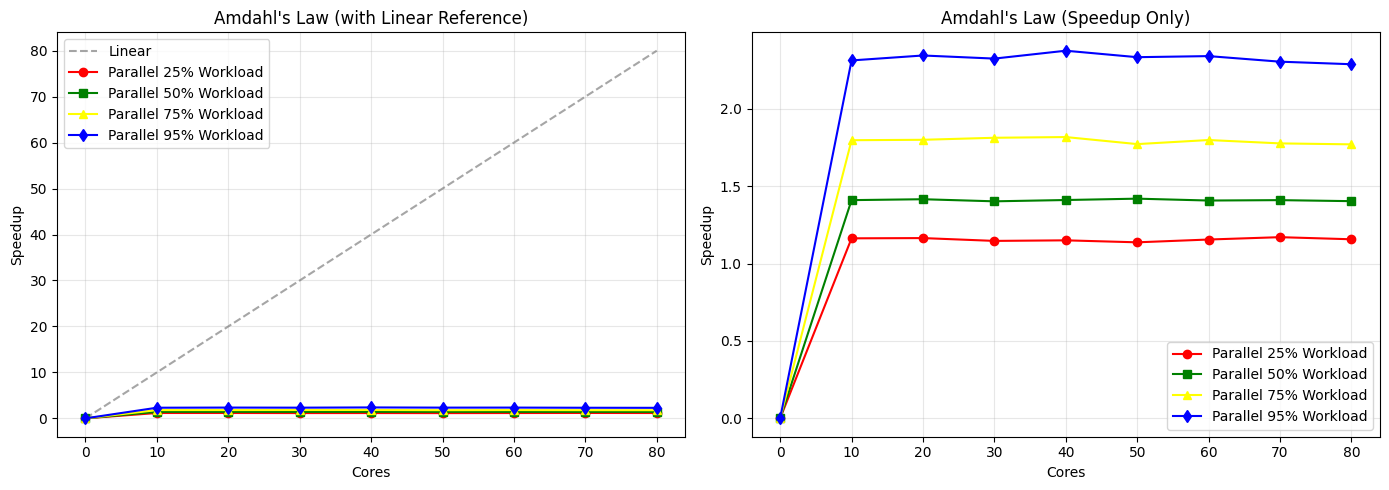

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Read CSV data
data = np.genfromtxt("benchmark_results.csv", delimiter=",", skip_header=1)

# Remove the first column
data = data[:, 1:]

# Calculate mean runtime for each profile
runtime = np.mean(data, axis=1)

# Extract sequential and parallel runtimes
sequential_runtime = runtime[0]
parallel_25percent = runtime[1:9]
parallel_50percent = runtime[9:17]
parallel_75percent = runtime[17:25]
parallel_95percent = runtime[25:33]

# Prepare x-axis and speedup calculations (including 0 point)
xpoints = np.arange(0, 90, 10)
ypoints_linear = xpoints

# Calculate speedups (prepend 0 for the zero point)
ypoints_25 = np.concatenate([[0], sequential_runtime / parallel_25percent])
ypoints_50 = np.concatenate([[0], sequential_runtime / parallel_50percent])
ypoints_75 = np.concatenate([[0], sequential_runtime / parallel_75percent])
ypoints_95 = np.concatenate([[0], sequential_runtime / parallel_95percent])

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: With linear reference
ax1.plot(xpoints, ypoints_linear, label='Linear', linestyle='--', alpha=0.7, color='gray')
ax1.plot(xpoints, ypoints_25, label='Parallel 25% Workload', marker='o', color='red')
ax1.plot(xpoints, ypoints_50, label='Parallel 50% Workload', marker='s', color='green')
ax1.plot(xpoints, ypoints_75, label='Parallel 75% Workload', marker='^', color='yellow')
ax1.plot(xpoints, ypoints_95, label='Parallel 95% Workload', marker='d', color='blue')
ax1.set_title("Amdahl's Law (with Linear Reference)")
ax1.set_xlabel("Cores")
ax1.set_ylabel("Speedup")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Without linear reference
ax2.plot(xpoints, ypoints_25, label='Parallel 25% Workload', marker='o', color='red')
ax2.plot(xpoints, ypoints_50, label='Parallel 50% Workload', marker='s', color='green')
ax2.plot(xpoints, ypoints_75, label='Parallel 75% Workload', marker='^', color='yellow')
ax2.plot(xpoints, ypoints_95, label='Parallel 95% Workload', marker='d', color='blue')
ax2.set_title("Amdahl's Law (Speedup Only)")
ax2.set_xlabel("Cores")
ax2.set_ylabel("Speedup")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()